<a href="https://colab.research.google.com/github/vadim-privalov/Neiroset_Novosibirsk/blob/main/%D0%A3%D1%81%D0%BA%D0%BE%D1%80%D1%8F%D0%B5%D0%BC_%D1%80%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ускоряем распознавание текста 

# Speed up text recognition

В этом уроке мы научися ускорять распознавания текста при помощи графических процессоров. 

In this tutorial we will learn how to speed up text recognition using GPUs.

Для этого здесь мы воспользуемся эффективной и точной моделью детектора текста сцены (EAST) и запустим ее на модуле dnn (deep neural network) OpenCV с использованием графического процессора NVIDIA.

To do this, here we will use an efficient and accurate Scene Text Detector (EAST) model and run it on an OpenCV dnn (deep neural network) module using an NVIDIA GPU.

А затем сравним с обычным вариантом и увидим насколько сильно разница пропускной способности FPS.





And then we will compare with the usual option and see how much the difference in FPS bandwidth is.

> **EAST** он же **efficient and accurate scene text detector**, он же  **эффективный и точный детектор текста сцены** -  это простой, но мощный подход для обнаружение текста уровне слова или строки. Этот алгоритм состоит из полностью сверточной сети с состоянием слияния без максимального подавления (NMS).

> **EAST** aka **efficient and accurate scene text detector** aka **efficient and accurate scene text detector** is a simple yet powerful approach for word or line level text detection. This algorithm consists of a fully convolutional merge state network without maximum suppression (NMS).

Ниже можно увидеть его архитектуру:




Below you can see its architecture:

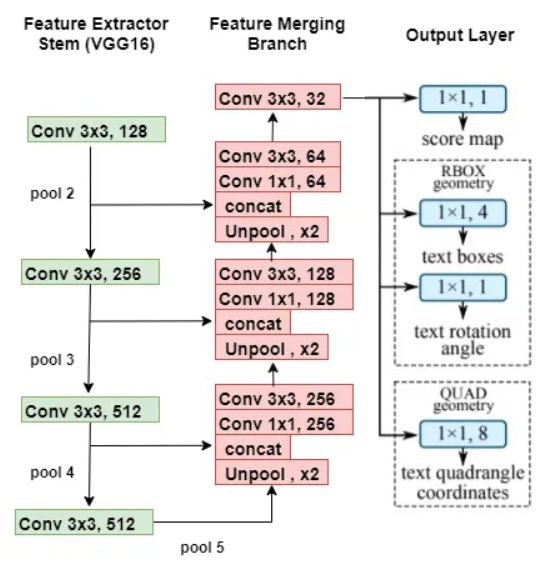

Еще нам ниже встретиться новые понятия, поэтому сразу их обговорим тут: 

We will also meet new concepts below, so we will immediately discuss them here:

> **Blob** - это группа связанных пикселей в изображении, которые имеют общее свойство (например, значение оттенков серого).



> **Blob** is a group of related pixels in an image that share a common property (for example, a grayscale value).

Давайте сначала напишем код, который будет проверять, насколько мы ускоряемся, запустив модель обнаружения текста на нашем процессоре по сравнению с графическим процессором

К сожалению, запустить на GPU в колабе у нас не получится, зато при правильной настройке локально все успешно будет работать. С инструкцией по установке обязательно ознакомьтесь в архиве этого урока.

In [1]:

# установим и распакуем архив
# install and unpack the archive
!wget http://dataudt.ru/datasets/cv/Lesson_18.Using_GPU.zip
!unzip -qq Lesson_18.Using_GPU.zip
%cd Using_GPU

--2022-02-11 06:28:42--  http://dataudt.ru/datasets/cv/Lesson_18.Using_GPU.zip
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91006135 (87M) [application/zip]
Saving to: ‘Lesson_18.Using_GPU.zip’

Lesson_18.Using_GPU 100%[===================>]  86.79M  22.8MB/s    in 4.2s    

2022-02-11 06:28:46 (20.5 MB/s) - ‘Lesson_18.Using_GPU.zip’ saved [91006135/91006135]

/content/Using_GPU


In [2]:

# импортируем необходимые пакеты
# import the necessary packages
from east import EAST_OUTPUT_LAYERS
import numpy as np
import time
import cv2


In [3]:
# создадим отдельный словарь с аргументами 
# create a separate dictionary with arguments 

args = {
  # путь к входному изображению 
  # path to input image
  "image" : "/content/Using_GPU/images/image.jpg", 
  # путь к входному детектору текста EAST 
  # path to input text detector EAST
  "east": '/content/Using_GPU/frozen_east_text_detection.pb', 
  #  ширина измененного изображения (должна быть кратна 32) 
  # the width of the resized image (must be a multiple of 32)
  "width": 320, 
  # высота измененного изображения (должна быть кратна 32) 
  # the height of the resized image (must be a multiple of 32)
  "height": 320, 
  # минимальная вероятность, необходимая для проверки области текста 
  # minimum probability needed to validate a region of text
  "min-conf": 0.5,
  # немаксимальный порог подавления 
  # non-maximum suppression threshold
  "nms-thresh": 0.4,  
  # флаг, указывающий, следует ли использовать GPU 
  # flag indicating whether to use GPU
  "use-gpu": False 
}

In [4]:
# загружаем предварительно обученный детектор текста EAST
# load the pre-trained EAST text detector
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet(args["east"])

# проверяем, будем ли мы использовать GPU


if args["use-gpu"]:
    # устанавливаем CUDA в качестве предпочтительного
    #  вычислительного сервера и конкретного целевого устройства
    # set CUDA as the preferable backend and target
	print("[INFO] setting preferable backend and target to CUDA...")
	net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
	net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

# иначе мы просто используем наш процессор
# otherwise we are using our CPU
else:
	print("[INFO] using CPU for inference...")

# загружаем входное изображение, а затем устанавливаем
# новые значения ширины и высоты на основе аргументов
#  командной строки
# load the input image and then set the new width and height values
# based on our command line arguments
image = cv2.imread(args["image"])
(newW, newH) = (args["width"], args["height"])

# создаем блоб из изображения, 
# задаем его в качестве входа для сети и инициализируем список, 
# который записывает количество времени,
# затрачиваемое на каждый проход 
# construct a blob from the image, set the blob as input to the
# network, and initialize a list that records the amount of time
# each forward pass takes
print("[INFO] running timing trials...")
blob = cv2.dnn.blobFromImage(image, 1.0, (newW, newH),
	(123.68, 116.78, 103.94), swapRB=True, crop=False)
net.setInput(blob)
timings = []

# делаем цикл на 500 итераций, чтобы получить хорошее
# приближение к тому, сколько 
# времени займет каждый проход 
# loop over 500 trials to obtain a good approximation to how long
# each forward pass will take
for i in range(0, 500):
    # время прямого распространения 
    # time the forward pass
	start = time.time()
	(scores, geometry) = net.forward(EAST_OUTPUT_LAYERS)
	end = time.time()
	timings.append(end - start)

# показываем среднее время предсказания текста
# show average timing information on text prediction
avg = np.mean(timings)
print("[INFO] avg. text detection took {:.6f} seconds".format(avg))


[INFO] loading EAST text detector...
[INFO] using CPU for inference...
[INFO] running timing trials...
[INFO] avg. text detection took 0.440614 seconds


Ниже в таблице представлено время выполнения сети на моем компьютере при 10,100 и 500 эпохах. Результаты могут отличаться на разных компьютерах.

The table below shows the network execution times on my computer at 10,100 and 500 epochs. Results may vary on different computers.

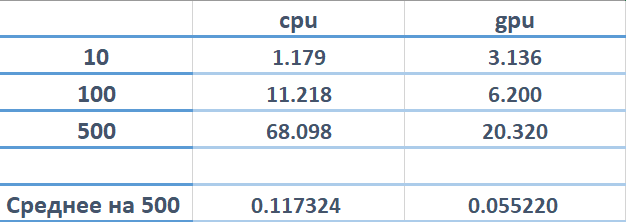

Удивительно, но результаты при маленькой итерации лучше на cpu, так для для запуска gpu нужно время, однако на больших данных она в разы быстрее. Так например за 500 итераций cpu обрабатывает 1 кадр примерно за 0.117 сек, в то время gpu =  0.055

Surprisingly, the results with small iterations are better on cpu, since it takes time to run gpu, but on big data it is much faster. So, for example, for 500 iterations, cpu processes 1 frame in about 0.117 seconds, while gpu = 0.055

После наглядного сравнения, попробуйте самостоятельно локально запустить файл text_detection_video.py при помощи командной строки (в начале файла есть инструкция) и в режиме реального времени распознать любой текст. 

After a visual comparison, try to run the text_detection_video.py file locally yourself using the command line (there is an instruction at the beginning of the file) and recognize any text in real time.